## Normalized to 1

In [1]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
alpha = 1
%timeit random.betavariate(alpha, alpha)

2.1 µs ± 40.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [3]:
alpha = 2
%timeit random.betavariate(alpha, alpha)

5.05 µs ± 56.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [4]:
class StochasticFragmentation:
    def __init__(self, alpha, prob):
        """
        alpha : 
        prob  : probability of keeping the right segment
        """
        self.alpha            = alpha
        self.prob             = prob
        self.expon            = 2*alpha - 1
        self.normC            = 1.0 # normalization constant
        self.probability_list = [1.0]
        self.length_list      = [1.0]
        self.flag_list        = [True]
        self.choose_pivot     = self.betadist
        pass

    def reset(self):
        self.normC            = 1.0 # normalization constant
        self.probability_list = [1.0]
        self.length_list      = [1.0]
        self.flag_list        = [True]
        
    def set_pivot_choosing_method(self, method='logistic'):
        """
        method  : way to choose the pivot point of a given segment
        returns : random value in [0, 1]
        """
        if method is 'logistic':
            self.choose_pivot = self.logistic_choice
            pass
        self.choose_pivot = self.betadist
        pass
    
    def betadist(self):
        """gives a random number from beta distribution"""
#         print("betadist")
        return random.betavariate(self.alpha,self.alpha)
    
    def logistic_xn(self, n, a=2):
        x0 = random.random()
        x1 = 0
        if n < 0:
            print("n cannot be negative")
            n = 1
            pass
        for i in range(n):
            x1 = a * x0 * (1-x0)
            x0 = x1
            pass
        return x0

    def logistic_choice(self):
#         print("logistic_choice")
        beta = self.alpha - 1
        RR = self.logistic_xn(beta)
        RRp = 1 - RR
        r = random.random()
        if r < 0.5:
            return RR
        return RRp
    
        
    def decision(self):
        """
        decides with a given probability whether to keep the right part
        """
        if self.prob > random.random():
            return True
        else: 
            return False
        
    def splitting(self, segment):
        """
        splits a given segment. left and right are endpoints of the segment
        segment : length of a segment
        returns : 
            xL -> length of the left segment
            xR -> length of the right segment
            flag -> keeping the right segment
            xLp, xRp -> probability(unnormalized) for being selected
            change -> change of normalization const
        """
        xL = segment * self.choose_pivot()
        xR = segment - xL
        flag = self.decision()
        xLp = xL**self.expon
        xRp = xR**self.expon
        change = xLp + xRp - segment**self.expon
        return xL, xR, flag, xLp, xRp, change
    
    def pickindex(self):
        """
        picks up a segment to be subsequently split
        """
        r = random.uniform(0, 1)
        sum_ = 0
        for index in range(len(self.probability_list)):
            sum_ += self.probability_list[index]/self.normC
            if sum_ < r:
                continue
            else:
                return index
            pass
        print("out of range. return None")
        pass
    
    def number_length(self):

        lengths = np.array(self.length_list)
        lengths = lengths[self.flag_list]
        N = lengths.shape[0]
        M = np.sum(lengths)
        
#         M, N = 0, 0
#         for i in range(len(self.flag_list)):
#             if self.flag_list[i]:
#                 N += 1
#                 M += self.length_list[i]
#                 pass
#             pass
#         if abs(M1-M) > 1e-10:
#             print("not equal")
        return N, M
    
    
    def view(self):
        print("viewing status")
        print("alpha = ", self.alpha)
        print("keeping probability ", self.prob)
        print("<length> <flag> <probability>")
        for i in range(len(self.length_list)):
            print("{:.5e}, {:.5e}, {:5}".format(self.length_list[i],
                                            self.probability_list[i]/self.normC,
                                            self.flag_list[i]
                                            ))
            pass
        print(np.sum(self.length_list))
        print(np.sum(self.length_list))
        pass
    
    def one_time_step(self):
        index = self.pickindex()
        if (type(index) == int) and self.flag_list[index]:

            xL, xR, flag, xLp, xRp, change = self.splitting(self.length_list[index])

            self.length_list[index] = xL
            self.length_list.append(xR)
            self.flag_list.append(flag)
            self.probability_list[index] = xLp 
            self.probability_list.append(xRp)
            self.normC += change
            pass
        
        pass
    
    
    def run(self, total_iteration, min_iteration, iteration_step):
        iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
        N_realization = []
        M_realization = []

        for i in range(total_iteration + 1):
#             print("time step ", i)
            self.one_time_step()

            if i+1 in iteration_list:
                N, M = self.number_length()
                N_realization.append(N)
                M_realization.append(M)
            pass

        N_list = np.array(N_realization)
        M_list = np.array(M_realization)

        return N_list, M_list

In [23]:
a = StochasticFragmentation(2, 0.75)

In [24]:

a.one_time_step()
a.view()

viewing status
alpha =  2
keeping probability  0.75
<length> <flag> <probability>
7.50486e-01, 9.64553e-01,     1
2.49514e-01, 3.54473e-02,     1
1.0
1.0


In [27]:
%timeit a.one_time_step()

3.57 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit a.run(100000, 50000, 2000)

312 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
def ensemble_average(sf, total_iteration = 1000, min_iteration = 100, iteration_step = 100, ensemble_size = 1000):

    data_points = int ((total_iteration - min_iteration)/iteration_step + 1)
    N_ensemble = np.zeros(data_points)
    M_ensemble = np.zeros(data_points)
    step = ensemble_size // 100
    
    for i in range(ensemble_size):
        sf.reset()
        if i % step == 0:
            print("iteration ", i)
        N_list, M_list = sf.run(total_iteration, min_iteration, iteration_step)
        N_ensemble += N_list
        M_ensemble += M_list
        pass
    
    N_average = N_ensemble/ensemble_size
    M_average = M_ensemble/ensemble_size
    
    return N_average, M_average

In [12]:
a = StochasticFragmentation(2, 0.75)
N_average, M_average = ensemble_average(a, 20_000, 5_000, 500, 500)

iteration  0
iteration  20
iteration  40
iteration  60
iteration  80
iteration  100
iteration  120
iteration  140
iteration  160
iteration  180
iteration  200
iteration  220
iteration  240
iteration  260
iteration  280
iteration  300
iteration  320
iteration  340
iteration  360
iteration  380
iteration  400
iteration  420
iteration  440
iteration  460
iteration  480
iteration  500
iteration  520
iteration  540
iteration  560
iteration  580
iteration  600
iteration  620
iteration  640
iteration  660
iteration  680
iteration  700
iteration  720
iteration  740
iteration  760
iteration  780
iteration  800
iteration  820
iteration  840
iteration  860
iteration  880
iteration  900
iteration  920
iteration  940
iteration  960
iteration  980
iteration  1000
iteration  1020
iteration  1040
iteration  1060
iteration  1080
iteration  1100
iteration  1120
iteration  1140
iteration  1160
iteration  1180
iteration  1200
iteration  1220
iteration  1240
iteration  1260
iteration  1280
iteration  1300


0.7812531084962726


Text(0, 0.5, 'ln N')

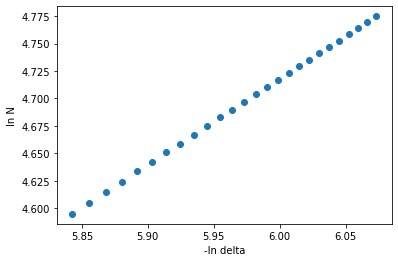

In [14]:
N_log = np.log(N_average)
minus_delta_log = N_log - np.log(M_average)
slope, intercept = np.polyfit(minus_delta_log, N_log, 1)
print(slope)
plt.plot(minus_delta_log, N_log, "o")
plt.xlabel("-ln delta")
plt.ylabel("ln N")
# plt.show()

0.7784419246258479


Text(0, 0.5, 'ln N')

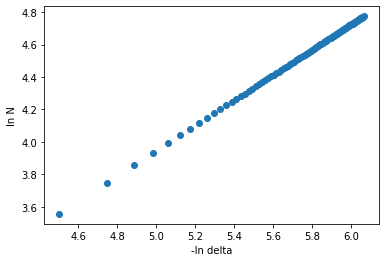

In [12]:
N_log = np.log(N_average)
minus_delta_log = N_log - np.log(M_average)
slope, intercept = np.polyfit(minus_delta_log, N_log, 1)
print(slope)
plt.plot(minus_delta_log, N_log, "o")
plt.xlabel("-ln delta")
plt.ylabel("ln N")
# plt.show()
print(0.7784419246258479)

## Parallel Code

In [22]:
import multiprocessing as mp

In [38]:
def ensemble_average(args=dict()):
    sf = args['obj']
    total_iteration = args['total_iteration']
    min_iteration = args['min_iteration']
    iteration_step = args['iteration_step']
    ensemble_size = args['ensemble_size']
    
    data_points = int ((total_iteration - min_iteration)/iteration_step + 1)
    N_ensemble = np.zeros(data_points)
    M_ensemble = np.zeros(data_points)
    step = ensemble_size // 100
    
    for i in range(ensemble_size):
        sf.reset()
        if i % step == 0:
            print("iteration ", i)
        N_list, M_list = sf.run(total_iteration, min_iteration, iteration_step)
        N_ensemble += N_list
        M_ensemble += M_list
        pass
    
    N_average = N_ensemble/ensemble_size
    M_average = M_ensemble/ensemble_size
    
    return N_average, M_average

In [32]:
N_average, M_average = ensemble_average({"obj":StochasticFragmentation(2, 0.75),
                  "total_iteration":10000,
                  "min_iteration":5000,
                  "iteration_step":500,
                  "ensemble_size":200,
                 })

iteration  0
iteration  2
iteration  4
iteration  6
iteration  8
iteration  10
iteration  12
iteration  14
iteration  16
iteration  18
iteration  20
iteration  22
iteration  24
iteration  26
iteration  28
iteration  30
iteration  32
iteration  34
iteration  36
iteration  38
iteration  40
iteration  42
iteration  44
iteration  46
iteration  48
iteration  50
iteration  52
iteration  54
iteration  56
iteration  58
iteration  60
iteration  62
iteration  64
iteration  66
iteration  68
iteration  70
iteration  72
iteration  74
iteration  76
iteration  78
iteration  80
iteration  82
iteration  84
iteration  86
iteration  88
iteration  90
iteration  92
iteration  94
iteration  96
iteration  98
iteration  100
iteration  102
iteration  104
iteration  106
iteration  108
iteration  110
iteration  112
iteration  114
iteration  116
iteration  118
iteration  120
iteration  122
iteration  124
iteration  126
iteration  128
iteration  130
iteration  132
iteration  134
iteration  136
iteration  138
itera

In [51]:
cpu_count = mp.cpu_count() - 1 # for safety

pool = mp.Pool(cpu_count)

arguments = [{"obj":StochasticFragmentation(2, 0.75),
                  "total_iteration":100_000,
                  "min_iteration":50_000,
                  "iteration_step":5_000,
                  "ensemble_size":1000,
                 } for i in range(cpu_count)]
    
results = pool.map(ensemble_average, [args for args in arguments])

pool.close()

print(results[:10])

# N_average, M_average = ensemble_average()

iteration  0
iteration  0
iteration  0
iteration  10
iteration  10
iteration  10
iteration  20
iteration  20
iteration  20
iteration  30
iteration  30
iteration  30
iteration  40
iteration  40
iteration  40
iteration  50
iteration  50
iteration  50
iteration  60
iteration  60
iteration  60
iteration  70
iteration  70
iteration  80
iteration  70
iteration  80
iteration  90
iteration  80
iteration  90
iteration  90
iteration  100
iteration  110
iteration  100
iteration  100
iteration  120
iteration  110
iteration  110
iteration  130
iteration  120
iteration  120
iteration  130
iteration  140
iteration  130
iteration  140
iteration  150
iteration  140
iteration  160
iteration  150
iteration  170
iteration  160
iteration  150
iteration  180
iteration  170
iteration  160
iteration  180
iteration  190
iteration  170
iteration  190
iteration  180
iteration  200
iteration  190
iteration  200
iteration  210
iteration  200
iteration  210
iteration  220
iteration  210
iteration  220
iteration  22

In [53]:
N_average, M_average  = 0, 0
for res in results:
    N_average += res[0]
    M_average += res[1]
    pass

N_average = N_average/len(results)
M_average = M_average/len(results)

print(N_average)
print(M_average)

[100.55833333 103.03633333 105.38533333 107.597      109.65133333
 111.64566667 113.56033333 115.351      117.08866667 118.78066667
 120.386     ]
[0.2891737  0.28709729 0.28525351 0.28356821 0.28194546 0.28054362
 0.27919888 0.27806846 0.27686848 0.27575069 0.27472949]


0.7787358405435251


Text(0, 0.5, 'ln N')

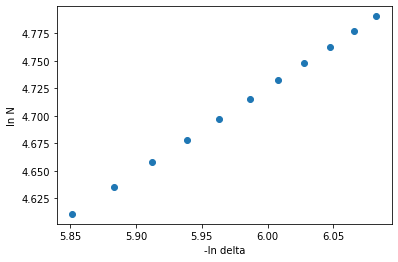

In [54]:
N_log = np.log(N_average)
minus_delta_log = N_log - np.log(M_average)
slope, intercept = np.polyfit(minus_delta_log, N_log, 1)
print(slope)
plt.plot(minus_delta_log, N_log, "o")
plt.xlabel("-ln delta")
plt.ylabel("ln N")
# plt.show()

## Idea to make it faster

1. each insert takes 5 times more time than just assigining value. because "insert" method inserts in some ranodm position 
2. same is not true for append. appends always inserts at the end
3. so we only need to replace insert method with something else
4. if we can find something where ordering or sequencing does not matter, this will be resolved
5. instead of points we can work with segment length only. and corresponding flag and probability. Like the table bellow

| length  | flag  | probability  |
|---|---|---|
|   |   |   |
|   |   |   |  
|   |   |   | 

7. Probably this can be made even faster by not using append in each iteration

# Performance
| method  | time
|---|---|
realization_value    | $1.19$ s
realization_value_v2 | $241$ ms

realization_value_v2 is $~5$ times faster

# Results
1. slope with realization_value    $0.779388458353189$
2. slope with realization_value_v2 $0.7841054354669876$


In [34]:
index = 1
type(index) == int

True

In [35]:
type(int)

type

In [36]:
type

type

In [37]:
type(type)

type